<a href="https://colab.research.google.com/github/geligeli/laser-cut-sat-layouter/blob/main/DrawerLayoutOptimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
!pip install ortools svgwrite

In [233]:
from __future__ import annotations
import math
import svgwrite
from IPython.display import SVG
from ortools.sat.python import cp_model

def CompututeNumberOfTabs(tabsize: float, edgeLength: float):
  numTabs = 2*int(edgeLength / (2*tabsize) - 3/2)+1
  a = 0.5*(edgeLength-numTabs*tabsize)
  return numTabs, a

class Rect:
  def __init__(self, h: float, w: float):
    self.h = h
    self.w = w
    self.l_contact = None
    self.r_contact = None
    self.t_contact = None
    self.b_contact = None
    self.internal_contacts = []
  
  def __str__(self):
    return "Rect(h=%f, w=%f, l_contact=%s, r_contact=%s, t_contact=%s, b_contact=%s, num_internal_contacs=%d)"%(self.h, self.w, self.l_contact, self.r_contact, self.t_contact, self.b_contact, len(self.internal_contacts))

  def sideLen(self, side: str) -> float:
    assert(side in ('l','r','t','b'))
    if side in ('l','r'):
      return self.h
    else:
      return self.w

  def sideContactState(self, side: str) -> int:
    s = self.sideContact(side)
    if s is None:
      return 0
    if s.rectA == self:
      return 1
    return -1

  def sideContact(self, side: str):
    return self.__dict__[side + '_contact']

  def setSideContact(self, side: str, contact):
    assert(self.__dict__[side + '_contact'] is None)
    self.__dict__[side + '_contact'] = contact

  def addInternalContact(self, contact):
    self.internal_contacts.append(contact)

  def connect(self, side: str, other: Rect, otherSide: str):  
    SideContactLine(self, side, other, otherSide)

  def connectToInternalLine(self, side: str, other: Rect, orientation: str, offset: float):  
    InternalContactLine(self, side, other, orientation, offset)

  def innerContactSlots(self, tabsize: float, thickness: float):
    for c in self.internal_contacts:
      if c.sideBOrientation == 'x':
        ntabs, a = CompututeNumberOfTabs(tabsize, self.w)
        x0 = a
        for i in range(ntabs):
          if i%2 == 0:
            yield [(x0, c.sideBOffset - thickness/2),
              (x0, c.sideBOffset + thickness/2),
              (x0+tabsize, c.sideBOffset + thickness/2),
              (x0+tabsize, c.sideBOffset - thickness/2),
              (x0, c.sideBOffset - thickness/2)]
          x0 += tabsize
      else:
        ntabs, a = CompututeNumberOfTabs(tabsize, self.h)
        y0 = a
        for i in range(ntabs):
          if i%2 == 0:
            yield [(c.sideBOffset - thickness/2, y0),
              (c.sideBOffset + thickness/2, y0),
              (c.sideBOffset + thickness/2, y0+tabsize),
              (c.sideBOffset - thickness/2, y0+tabsize),
              (c.sideBOffset - thickness/2, y0)]
          y0 += tabsize

  def lines(self, thickness: float, tabsizeMultiplier: float = 3.0):
    tabsize = tabsizeMultiplier * thickness
    r = []
    r.append([p for p in self.points(tabsize, thickness)])
    r.extend(self.innerContactSlots(tabsize, thickness))
    return r

  def points(self, tabsize: float, thickness: float):
    nTabsHorizontal, aHorizontal = CompututeNumberOfTabs(tabsize, self.w)
    nTabsVertical, aVertical = CompututeNumberOfTabs(tabsize, self.h)

    scs0 = self.sideContactState('t')
    scs1 = self.sideContactState('r')
    scs2 = self.sideContactState('b')
    scs3 = self.sideContactState('l')

    x,y=0,0
    yield x,y
    # Top
    if scs0 != 0:
      x+=aHorizontal
      yield x,y
      for _ in range(nTabsHorizontal):
        y = (-scs0,0)[_%2]*thickness
        yield x,y
        x+=tabsize
        yield x,y
      y=0
      yield x,y
    x,y = self.w, 0
    yield x,y
    # right
    if scs1 != 0:
      y+=aVertical
      yield x,y
      for _ in range(nTabsVertical):
        x = self.w + (scs1,0)[_%2]*thickness
        yield x,y
        y+=tabsize
        yield x,y
      x=self.w
      yield x,y
    x,y = self.w, self.h
    yield x,y
    #bottom
    if scs2 != 0:
      x-=aHorizontal
      yield x,y
      for _ in range(nTabsHorizontal):
        y = self.h + (scs2,0)[_%2]*thickness
        yield x,y
        x-=tabsize
        yield x,y
      y=self.h
      yield x,y
    x,y = 0, self.h
    yield x,y
    #left
    if scs3 != 0:
      y-=aVertical
      yield x,y
      for _ in range(nTabsVertical):
        x = (-scs3,0)[_%2]*thickness
        yield x,y
        y-=tabsize
        yield x,y
      x=0
      yield x,y
    x,y = 0, 0
    yield x,y

class SideContactLine:
  def __init__(self, rectA : Rect, sideA : str, rectB : Rect, sideB : str):
    assert(rectA.sideLen(sideA) == rectB.sideLen(sideB))
    self.rectA = rectA
    self.rectB = rectB
    self.sideA = sideA
    self.sideB = sideB
    rectA.setSideContact(sideA, self)
    rectB.setSideContact(sideB, self)
  def length(self) -> float:
    return rectA.siteLen(sideA)

class InternalContactLine:
  def __init__(self, rectA : Rect, sideA : str, rectB : Rect, sideBOrientation : str, sideBOffset: float):
    assert(sideBOrientation in ('x','y'))
    if sideBOrientation == 'x':
      assert(rectA.sideLen(sideA) == rectB.w)
    else:
      assert(rectA.sideLen(sideA) == rectB.h)
    self.rectA = rectA
    self.rectB = rectB
    self.sideA = sideA
    self.sideBOrientation = sideBOrientation
    self.sideBOffset = sideBOffset
    rectA.setSideContact(sideA, self)
    rectB.addInternalContact(self)
  def length(self) -> float:
    return rectA.siteLen(sideA)

class BoundingBox:
  def __init__(self, points=None):
    if points is None:
      self.min_x = None
      self.max_x = None
      self.min_y = None
      self.max_y = None
      return
    self.min_x, self.max_x = min([p[0] for p in points]), max([p[0] for p in points])
    self.min_y, self.max_y = min([p[1] for p in points]), max([p[1] for p in points])

  def __str__(self):
    return "(%f,%f),(%f,%f)"%(self.min_x, self.min_y, self.max_x, self.max_y)

  def extend(self, other: BoundingBox):
    if self.min_x is None:
      self.min_x = other.min_x
      self.min_y = other.min_y
      self.max_x = other.max_x
      self.max_y = other.max_y
      return
    self.min_x = min(self.min_x, other.min_x)
    self.min_y = min(self.min_y, other.min_y)
    self.max_x = max(self.max_x, other.max_x)
    self.max_y = max(self.max_y, other.max_y)

class Layout:
  def __init__(self):
    self.polylines = []
    self.boundingBox = BoundingBox()
    self.part_offset=3
 
  def render(self):
    dwg = svgwrite.Drawing()
    y_offset = 0
    width=0
    for points in self.polylines:
      bb=BoundingBox()
      group = dwg.g()
      for p in points:
        bb.extend(BoundingBox(p))
        line=dwg.polyline(points=p,fill='none',stroke='black')
        line["stroke-width"]="0.1"
        group.add(line)
      group["transform"]="translate(%f,%f)"%(-bb.min_x, y_offset-bb.min_y)
      y_offset += bb.max_y-bb.min_y+self.part_offset
      width = max([width, bb.max_x-bb.min_x])
      dwg.add(group)
    height = y_offset-self.part_offset
    dwg["viewBox"]="0 0 %f %f"%(width, height)
    dwg["width"]="%fmm"%width
    dwg["height"]="%fmm"%height
    return dwg

  def addPolyLines(self, polyLines):
    self.polylines.append(polyLines)

class MIPRect:
  def __init__(self, model, name, h, w, maxHeight, maxWidth):
    self.name = name
    self.model = model
    self.x = model.NewIntVar(0, maxWidth, name+'_x')
    self.y = model.NewIntVar(0, maxHeight, name+'_y')
    self.isRotated = model.NewBoolVar(name+'_is_rotated')
    self.h = h
    self.w = w
    maxX = maxWidth - self.w
    maxY = maxHeight - self.h
    maxXRotated = maxWidth - self.h
    maxYRotated = maxHeight - self.w
    model.Add(self.x <= maxX).OnlyEnforceIf(self.isRotated.Not())
    model.Add(self.y <= maxY).OnlyEnforceIf(self.isRotated.Not())
    model.Add(self.x <= maxXRotated).OnlyEnforceIf(self.isRotated)
    model.Add(self.y <= maxYRotated).OnlyEnforceIf(self.isRotated)

  def createIntervals(self, maxNumPlanes: int):
    self.x_interval = []
    self.y_interval = []
    self.x_rotated_interval = []
    self.y_rotated_interval = []
    self.is_present_on_plane = []
    self.is_rotated_present_on_plane = []
    for i in range(maxNumPlanes):
      is_present = self.model.NewBoolVar('%s_is_present_on_plane_%d'%(self.name, i))
      self.is_present_on_plane.append(is_present)
      self.x_interval.append(self.model.NewOptionalFixedSizeIntervalVar(self.x, self.w, is_present, self.name+'_x_interval_plane_%d'%i))
      self.y_interval.append(self.model.NewOptionalFixedSizeIntervalVar(self.y, self.h, is_present, self.name+'_y_interval_plane_%d'%i))
      is_rotated_present = self.model.NewBoolVar('%s_is_rotated_present_on_plane_%d'%(self.name, i))
      self.is_rotated_present_on_plane.append(is_rotated_present)
      self.x_rotated_interval.append(self.model.NewOptionalFixedSizeIntervalVar(self.x, self.h, is_rotated_present, self.name+'_x_rotated_interval_plane_%d'%i))
      self.y_rotated_interval.append(self.model.NewOptionalFixedSizeIntervalVar(self.y, self.w, is_rotated_present, self.name+'_y_rotated_interval_plane_%d'%i))
    self.model.Add(sum(self.is_present_on_plane+self.is_rotated_present_on_plane) == 1)
    self.model.AddMaxEquality(self.isRotated, self.is_rotated_present_on_plane)
    

class MIPLayout(Layout):
  def __init__(self, stockHeigh=300, stockWidth=500):
    Layout.__init__(self)
    self.stockHeigh = stockHeigh
    self.stockWidth = stockWidth
    self.part_offset=3
  
  def maxNumPlanes(self) -> int:
    return len(self.rectangles)

  def optimize(self, max_time_in_seconds=10.0):
    self.model = cp_model.CpModel()
    self.solver=cp_model.CpSolver()
    self.rectangles = []
    counter = 0
    for points in self.polylines:
      bb=BoundingBox()
      for p in points:
        bb.extend(BoundingBox(p))
      height = math.ceil(bb.max_y - bb.min_y)+3
      width = math.ceil(bb.max_x - bb.min_x)+3
      self.rectangles.append(MIPRect(self.model, '%d'%counter, height, width, self.stockHeigh, self.stockWidth))
      counter += 1
    for r in self.rectangles:
      r.createIntervals(self.maxNumPlanes())
    for i in range(self.maxNumPlanes()):
      self.model.AddNoOverlap2D([x.x_interval[i] for x in self.rectangles]+[x.x_rotated_interval[i] for x in self.rectangles],
                                [x.y_interval[i] for x in self.rectangles]+[x.y_rotated_interval[i] for x in self.rectangles])

    self.activePlanes = [self.model.NewBoolVar('plane_%d_is_active'%i) for i in range(self.maxNumPlanes())]
    for i in range(self.maxNumPlanes()):
      self.model.AddMaxEquality(self.activePlanes[i], [r.is_present_on_plane[i] for r in self.rectangles]+[r.is_rotated_present_on_plane[i] for r in self.rectangles])
    self.model.Minimize(sum(self.activePlanes))    
    self.solver.parameters.max_time_in_seconds = max_time_in_seconds
    self.status = self.solver.Solve(self.model)

  def render(self):
    statusName = self.solver.StatusName(self.status)
    assert(statusName in ('OPTIMAL', 'FEASIBLE'))
    for planeIndex in range(self.maxNumPlanes()):
      dwg = svgwrite.Drawing()
      dwg["viewBox"]="0 0 %f %f"%(self.stockWidth, self.stockHeigh)
      dwg["width"]="%fmm"%self.stockWidth
      dwg["height"]="%fmm"%self.stockHeigh
      hasContent = False
      for r, points in zip(self.rectangles, self.polylines):
        present = self.solver.Value(r.is_present_on_plane[planeIndex])
        rotatedPresent = self.solver.Value(r.is_rotated_present_on_plane[planeIndex])
        if present == 0 and rotatedPresent == 0:
          continue
        hasContent = True
        bb=BoundingBox()
        group = dwg.g()
        x=self.solver.Value(r.x)
        y=self.solver.Value(r.y)
        for p in points:
          bb.extend(BoundingBox(p))
          s='black'
          # if rotatedPresent == 1:
          #   box = svgwrite.shapes.Rect(insert=(x,y), size=(r.h, r.w), style="stroke: blue")
          #   s='red'
          # else:
          #   box = svgwrite.shapes.Rect(insert=(x,y), size=(r.w, r.h), style="stroke: blue")
          # box.fill(opacity=0.0)
          # dwg.add(box)
          line=svgwrite.shapes.Polyline(points=p,fill='none',stroke=s)
          line["stroke-width"]="0.1"
          group.add(line)
        if rotatedPresent == 1:
          transforms = ["translate(%f,%f)"%(self.solver.Value(r.x), self.solver.Value(r.y)),
                        "translate(%f,0)"%(bb.max_y - bb.min_y),
                        "rotate(90)",
                        "translate(%f,%f)"%(-bb.min_x, -bb.min_y)]
          group["transform"]=" ".join(transforms)
        else:
          group["transform"]="translate(%f,%f)"%(x-bb.min_x, y-bb.min_y)
        dwg.add(group)
      if hasContent:
        yield dwg

In [234]:
import math
import numpy as np
from collections import defaultdict
from ortools.sat.python import cp_model

## Collect data
a=[x.split('\t') for x in '''3	2.0	49	24
3	2.5	57	30
3	3.0	61	33
3	3.3	65	36
3	3.5	70	39
3	4	75	43
3	4.2	75	43
3	4.5	80	47
5	5	86	52
5	5.5	93	57
5	6.0	93	57
5	6.5	101	63
5	7.0	109	69
5	7.5	109	69
5	8.0	117	75'''.split('\n')]
a=[[int(u[0]), float(u[1]), float(u[2]), float(u[3])] for u in a]

## Setup model

MAX_HEIGHT=500
MAX_WIDTH=380
NUM_BOXES=len(a)
HEIGHT_COEFFS=np.array([int(math.ceil(x[0]*x[1]))+5 for x in a], dtype=np.int32)
WIDTH_COEFFS=np.array([int(x[2])+5 for x in a], dtype=np.int32)
MAX_WIDTH=420

# NUM_BOXES=4
# HEIGHT_COEFFS=[1,2,3,4]
# WIDTH_COEFFS=[4,5,6,10]
# FAKE_INF=1000
# MAX_WIDTH=20
model=cp_model.CpModel()
next_line_vars=[model.NewBoolVar('next_line_%d'%i) for i in range(1,NUM_BOXES)]

box_position=[0]
for i in range(1,NUM_BOXES):
  box_position.append(cp_model.LinearExpr.Sum(next_line_vars[:i]))


height_terms_for_line=defaultdict(lambda: [])
width_terms_for_line=defaultdict(lambda: [])
box_indicator_vars={}

height_terms_for_line[0].append(HEIGHT_COEFFS[0])
width_terms_for_line[0].append(WIDTH_COEFFS[0])

for box_index in range(1, NUM_BOXES):
  constraints_for_box=[]
  for line_index in range(box_index+1):
    var = model.NewBoolVar('box_%d_on_line_%d'%(box_index,line_index))
    model.Add(box_position[box_index]==line_index).OnlyEnforceIf(var)
    constraints_for_box.append(var)
    height_terms_for_line[line_index].append(HEIGHT_COEFFS[box_index]*var)
    width_terms_for_line[line_index].append(WIDTH_COEFFS[box_index]*var)
  model.Add(sum(constraints_for_box)==1)
  box_indicator_vars[box_index]=constraints_for_box

widths=[]
for k in width_terms_for_line:
  w=model.NewIntVar(0, MAX_WIDTH, 'widht_of_line_%d'%k)
  model.AddMaxEquality(w, width_terms_for_line[k])
  widths.append(w)

model.Add(sum(widths) <= MAX_WIDTH)

heights=[]
for k in height_terms_for_line:
  heights.append(sum(height_terms_for_line[k]))

HEIGHT=model.NewIntVar(0, MAX_HEIGHT, 'HEIGHT')

model.AddMaxEquality(HEIGHT, heights)
model.Minimize(HEIGHT)
solver = cp_model.CpSolver()
status = solver.Solve(model)


OPTIMAL


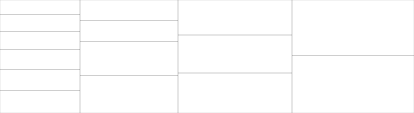

In [235]:
## Extract solution
FinalBoxWidths=np.array([solver.Value(x) for x in widths if solver.Value(x) > 0])
FinalBoxHeights=np.array([solver.Value(x) for x in heights if solver.Value(x) > 0])
BoxLinePositions=np.array([solver.Value(x) for x in box_position])



def RenderBoxes(FinalBoxWidths,FinalBoxHeights, BoxLinePositions, HEIGHT_COEFFS): 
  W=np.sum(FinalBoxWidths)
  H=np.max(FinalBoxHeights)
  dwg = svgwrite.Drawing(viewBox="0 0 %d %d"%(W,H))
  dwg["width"]='%dmm'%W
  dwg["height"]='%dmm'%H
  curLine=0
  verticalOffset=0
  for i in range(NUM_BOXES):
    if curLine != BoxLinePositions[i]:
      curLine=BoxLinePositions[i]
      verticalOffset=0
    horizontalOffset=np.sum(FinalBoxWidths[:curLine])
    scalingFactor=H/FinalBoxHeights[curLine]
    #print(scalingFactor,(verticalOffset,horizontalOffset),(scalingFactor*HEIGHT_COEFFS[i],FinalBoxWidths[curLine]))
    r=dwg.rect(insert=(float(horizontalOffset),float(verticalOffset)),
               size=(float(FinalBoxWidths[curLine]),float(scalingFactor*HEIGHT_COEFFS[i])),
               fill='none',
               stroke='black',
               stroke_width='0.1px')
    verticalOffset += scalingFactor*HEIGHT_COEFFS[i]
    dwg.add(r)
  return dwg


dwg=RenderBoxes(FinalBoxWidths,FinalBoxHeights, BoxLinePositions, HEIGHT_COEFFS)
SVG(dwg.tostring())



In [229]:

l=MIPLayout()

for i in range(3):
  for part in OpenBox(100,200,60):
    l.addPolyLines(part.lines(5))

l.optimize()


2


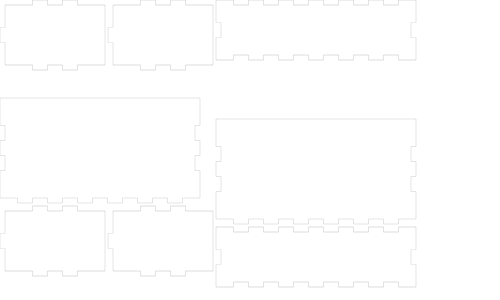

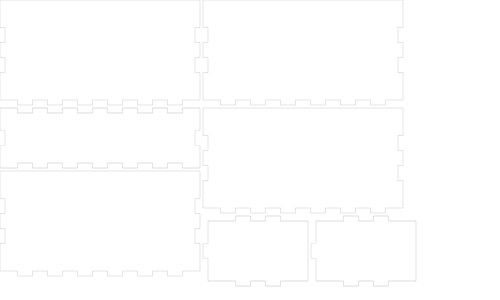

<svg baseProfile="full" height="300.000000mm" version="1.1" viewBox="0 0 500.000000 300.000000" width="500.000000mm" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><g transform="translate(0.000000,98.000000)"><polyline fill="none" points="0,0 200,0 200,27.5 195,27.5 195,42.5 200,42.5 200,57.5 195,57.5 195,72.5 200,72.5 200,100 182.5,100 182.5,105 167.5,105 167.5,100 152.5,100 152.5,105 137.5,105 137.5,100 122.5,100 122.5,105 107.5,105 107.5,100 92.5,100 92.5,105 77.5,105 77.5,100 62.5,100 62.5,105 47.5,105 47.5,100 32.5,100 32.5,105 17.5,105 17.5,100 0,100 0,72.5 5,72.5 5,57.5 0,57.5 0,42.5 5,42.5 5,27.5 0,27.5 0,0" stroke="black" stroke-width="0.1" /></g><g transform="translate(0.000000,206.000000) translate(105.000000,0) rotate(90) translate(5.000000,0.000000)"><polyline fill="none" points="0,0 60,0 60,27.5 65,27.5 65,42.5 60,42.5 60,57.5 65,57.5 65,72.5 60,72.5 60,100 37.5,100 37.5,105 22.5,105 22.5,

In [231]:

dwgs=[dwg for dwg in l.render()]
print(len(dwgs))

for d in dwgs:
  display(SVG(d.tostring()))

for d in dwgs:
  print(d.tostring())
